# Milestone 2 Phase 2

>- Nama      : Alsello Diveni Manuputty
>- Batch     : HCK 6 Pondok Indah
>- Phase     : 2
------
**Objective**
>Pada notebook ini akan dilakukan pengerjaan Milestone 2 fase 2 dimana akan dibuat model *Neural Language Processing* untuk memprediksi `sentimen` dari twitter. Pada kasus ini, analis ditugaskan oleh salah satu kantor berita untuk membuatkan sebuah model untuk memprediksi sentimen dari data yang berisi tweet. Karena resiko salah klasifikasi cukup fatal, maka perlu dilakukan *modelling* dengan berusaha untuk meningkatkan *`accuracy`* model. Dengan model ini, diharapkan kantor berita bisa meringankan kerja perusahaan dalam proses analisa sentimen dan bisa mengarahkan energi yang tersisa ke pekerjaan lain yang memang butuh seorang manusia untuk melakukannya.

**Link Deployment**
>Hasil dari notebook ini akan di deploy ke [link](https://huggingface.co/spaces/AlselloDM/Milestone_2_Phase_2) ini.

**Problem Statement**
>Baru-baru ini, mulai viral pemberitaan mengenai salah satu mantan pilot militer Amerika Serikat David Grusch yang menyatakan bahwa alien itu ada dan pemerintah AS menutup-nutupi kejadian yang pernah dialaminya. Kejadian ini viral karena memang ada pernyataan publik yang dihadiri juga oleh orang-orang yang bersangkutan dari pemerintahan AS dan juga diliput media AS. Pada pernyataan publik tersebut juga dihadiri oleh 2 orang lainnya yang juga memiliki pengalaman yang sama dengan David. Media pemberitaan Indonesia mencari seorang data scientist yang bisa melakukan analisa sentimen publik melalui tweet yang ada di twitter sebagai bahan tambahan dalam melakukan pemberitaan soal ini.

# Import Necessities

Sebelum dilakukan pembuatan notebook, akan di import dahulu segala kebutuhannya seperti library, ataupun metrik-metrik yang akan digunakan.

In [1]:
!pip install nltk
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TextVectorization,Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import gensim
from gensim.models import Word2Vec

sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# function warna
def random_colours(number_of_colors):
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('#E86DA4') for j in range(6)]))
    return colors

# Data Loading

Untuk pengerjaan notebook ini, digunakan dataset [ini](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) untuk proses training model.

In [4]:
# data loading
mentah = pd.read_csv('/content/twitter_training.csv',header = None)
mentah.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Selanjutnya akan diberi nama kolom untuk memudahkan proses selanjutnya.

In [5]:
# mengganti nama kolom
new_columns=["id","type","sentiment","tweet"]
mentah.columns = new_columns
mentah.head()

,id,type,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


### Data Overview
Supaya lebih jelas, akan dilakukan serangkaian proses data overview.

In [6]:
mentah.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   type       74682 non-null  object
 2   sentiment  74682 non-null  object
 3   tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
mentah.shape

(74682, 4)

In [8]:
mentah.isnull().sum()

id             0
type           0
sentiment      0
tweet        686
dtype: int64

Dari list kolom, terlihat bahwa ada 2 kolom yang tidak terlalu penting dalam analisis. Oleh karena itu akan dibuang saja.

In [9]:
mentah.drop(columns= ['id','type'], inplace=True)

In [10]:
mentah

,sentiment,tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


Selanjutnya perlu loading data inference yang diambil dengan metode scrapping. Untuk code yang digunakan didapatkan dari tutorial [ini](https://youtu.be/OK6b5vvjRzY). Dari tutorial ini dibagikan [link google colab](https://colab.research.google.com/drive/1H9ns2Zp9ubEErj5mXcTqIhx9v84m16pk?usp=sharing) ini dan selanjutnya data akan langsung saja di load disini. Nantinya data ini akan digunakan sebagai data inference karena untuk melatih model perlu ada label khusus di datasetnya. Nanti hasilnya akan di evaluasi juga di bagian data inference.

In [11]:
inf = pd.read_csv('/content/alien_ann.csv', delimiter = ';').drop(['created_at', 'id_str', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'lang', 'user_id_str', 'conversation_id_str', 'username', 'tweet_url'], axis=1)
inf

,full_text
0,Will someone please get David Grusch in a SCIF...
1,David Grusch told Liberation Times: “Congress...
2,David Grusch responds to Rep. Mike Turner’s co...
3,David Grusch told Liberation Times: “Congress...
4,The late Nat Kobitz... a key figure in the Dav...
...,...
725,6pm on @NewsNation: David Grusch - a veteran o...
726,UFO Whistleblower David Grusch says the US Gov...
727,Ross Coulthart on UFO whistleblower David Grus...
728,Ross Coulthart will be interviewing recently r...


Setelah selesai data loading akan dilanjutkan proses data cleaning.

# Data Cleaning

Proses selanjutnya adalah data cleaning. Proses ini dibutuhkan dalam segala macam analisis data sampai ke pembuatan model. Karena data yang "kotor", hanya akan menurunkan ketajaman analisis.

In [12]:
# drop missing value
mentah.dropna(inplace=True)

In [13]:
# cek missing value
mentah.isna().sum()

sentiment    0
tweet        0
dtype: int64

Karena ini adalah proses analisa sentimen, tweet yang berlabel irrelevant akan dibuang saja karena hanya akan memberatkan model dan tidak berpengaruh juga terhadap analisis.

In [14]:
# drop label irrelevant
mentah = mentah[mentah.sentiment != "Irrelevant"]
len(mentah)

61121

Setelah drop data, alangkah baiknya untuk dilakukan reset index agar data kembali utuh tanpa ada index yang ter-skip.

In [15]:
# reset index
mentah.reset_index(drop=True, inplace=True)

# Exploratory Data Analysis

Proses selanjutnya setelah data cleaning adalah eksplorasi data. Pada bagian ini akan ditemukan fakta-fakta baru mengenai data yang kemungkinan akan mendapat insight baru yang mungkin akan membantu pada saat evaluasi model.

Sebelum dilakukan eda, akan dilakukan copy data dahulu supaya data mentah tidak terganggu jika nanti diperlukan.

In [16]:
# copy data
df_eda = mentah.copy()

In [17]:
# jumlah sentimen target
df_eda["sentiment"].value_counts()

Negative    22358
Positive    20655
Neutral     18108
Name: sentiment, dtype: int64

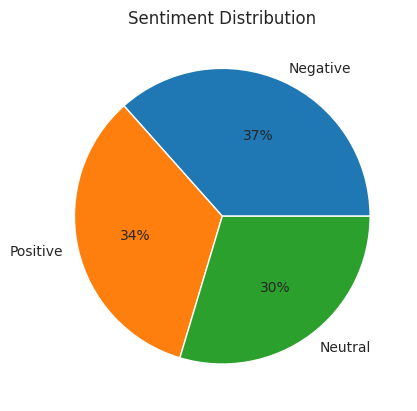

In [18]:
sentiment_counts = df_eda['sentiment'].value_counts()
labels = sentiment_counts.index.tolist()

# pie chart target
plt.pie(sentiment_counts, labels=labels, autopct='%.0f%%')
plt.title('Sentiment Distribution')
plt.show()

Terlihat untuk target sendiri datanya tidak terlalu imbalance. Terlihat juga bahwa sentimen negatif memiliki jumlah terbanyak pada data train. Disusul dengan sentimen positif dan yang terakhir sentimen netral.

Sampai sini, sepertinya tidak ada lagi yang bisa di eksplorasi. Untuk eksplorasi data selanjutnya, mungkin akan dilakukan setelah data di preprocessing.

# Data Preprocessing

Sama seperti bagian eda, sebelum dilakukan preprocessing akan dibuatkan copy datanya dahulu untuk jaga-jaga jika data eda masih dibutuhkan.

In [19]:
#copy data
df_pp = df_eda.copy()

### Sample Preprocessing

In [20]:
sample_text = df_pp.loc[6584]['tweet']

print(sample_text)

@ Blizzard _ Ent The fact that I'm suspended in Overwatch because I have a shaky WiFi connection is ridiculous. If I run into leave game, suspend me. If I have a bad connection and get back into the game, do you suspend me anyway?! Boococky. You're better than that. Please change it.


Sebelum dilakukan preprocessing kepada data train, akan dilakukan trialnya dulu ke sample_text supaya lebih jelas prosesnya.

In [21]:
# Case Folding
sample_text = sample_text.lower()
sample_text = re.sub(r'\d+', '', sample_text)
sample_text = sample_text.translate(str.maketrans("","", string.punctuation))
sample_text = sample_text.strip()

In [22]:
# Sentence Tokenization
sent_token = sent_tokenize(sample_text)
print(sent_token)

['blizzard  ent the fact that im suspended in overwatch because i have a shaky wifi connection is ridiculous if i run into leave game suspend me if i have a bad connection and get back into the game do you suspend me anyway boococky youre better than that please change it']


Proses tokenisasi melakukan tokenisasi berdasarkan satu kalimat.

In [23]:
# Word Tokenization
word_token = word_tokenize(sample_text)
print(word_token)

['blizzard', 'ent', 'the', 'fact', 'that', 'im', 'suspended', 'in', 'overwatch', 'because', 'i', 'have', 'a', 'shaky', 'wifi', 'connection', 'is', 'ridiculous', 'if', 'i', 'run', 'into', 'leave', 'game', 'suspend', 'me', 'if', 'i', 'have', 'a', 'bad', 'connection', 'and', 'get', 'back', 'into', 'the', 'game', 'do', 'you', 'suspend', 'me', 'anyway', 'boococky', 'youre', 'better', 'than', 'that', 'please', 'change', 'it']


Seperti yang terlihat, sent_tokenize melakukan tokenisasi untuk satu kalimat. Kalu word_tokenize melakukan tokenisasi tiap kata.

Selanjutnya akan dilakukan visualisasi token kata.

In [24]:
fdist = FreqDist(word_token)

In [25]:
fdist.most_common(2)

[('i', 3), ('the', 2)]

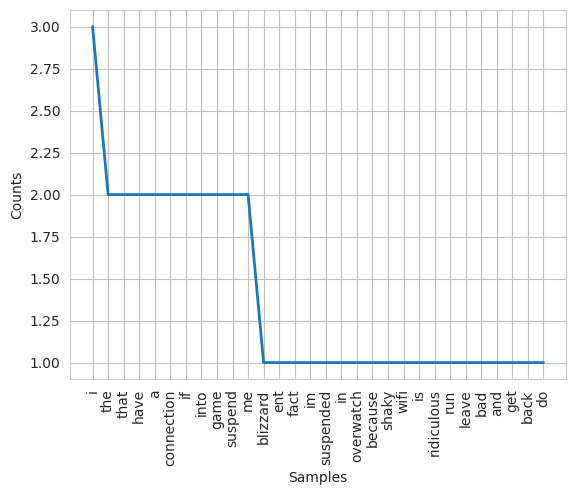

In [26]:
fdist.plot(30, cumulative=False)
plt.show()

Ternyata kata yang jumlah kemunculan nya tinggi tergolong dalam kata stopword. Selanjutnya akan dihandling dan akan dilihat kembali visualisasi jumlah kata di kalimat dan diamati perubahannya

In [27]:
# stopwords
stop_words = set(stopwords.words("english"))
print(stop_words)

{'himself', 'doing', 'as', 'that', 'mustn', 'whom', 'to', 'd', 'while', 'there', 'own', 'of', 'if', "you're", 'because', "doesn't", 'they', 'any', "shan't", 'off', 'nor', 'was', "hadn't", 'won', 'have', 'him', 'below', 'has', 'how', 'why', "didn't", 'were', 'mightn', "needn't", 'been', 'between', 'some', 'only', 'hadn', 'too', 'above', 'those', 'up', 'few', 'for', 'on', 'not', "you'll", 'haven', 'what', "aren't", 'and', 'by', 'before', 'will', 'myself', 'into', 'm', 'them', 'such', "you'd", 'under', 'couldn', 'yourselves', 'is', 'no', 'ma', 'against', "shouldn't", 'his', 'our', 'now', 'just', "couldn't", 'theirs', 'until', 'should', 'the', "won't", 'more', 'had', "should've", 'she', 're', 'so', 'yours', 'wouldn', 'didn', 'me', 'a', "haven't", 'did', "don't", 'but', 'this', "wasn't", 've', 'about', 'which', 'ain', 'during', 'then', 'll', 'shouldn', 'at', 'after', "isn't", "it's", 'my', 'don', "mightn't", 'very', 'doesn', 'it', "that'll", 'from', 'through', 'most', 'ours', 'other', 'am',

In [28]:
sent_filtered = []

for w in word_token:
    if w not in stop_words:
        sent_filtered.append(w)

print("Tokenized Sentence:", word_token)
print("Filterd Sentence:", sent_filtered)

Tokenized Sentence: ['blizzard', 'ent', 'the', 'fact', 'that', 'im', 'suspended', 'in', 'overwatch', 'because', 'i', 'have', 'a', 'shaky', 'wifi', 'connection', 'is', 'ridiculous', 'if', 'i', 'run', 'into', 'leave', 'game', 'suspend', 'me', 'if', 'i', 'have', 'a', 'bad', 'connection', 'and', 'get', 'back', 'into', 'the', 'game', 'do', 'you', 'suspend', 'me', 'anyway', 'boococky', 'youre', 'better', 'than', 'that', 'please', 'change', 'it']
Filterd Sentence: ['blizzard', 'ent', 'fact', 'im', 'suspended', 'overwatch', 'shaky', 'wifi', 'connection', 'ridiculous', 'run', 'leave', 'game', 'suspend', 'bad', 'connection', 'get', 'back', 'game', 'suspend', 'anyway', 'boococky', 'youre', 'better', 'please', 'change']


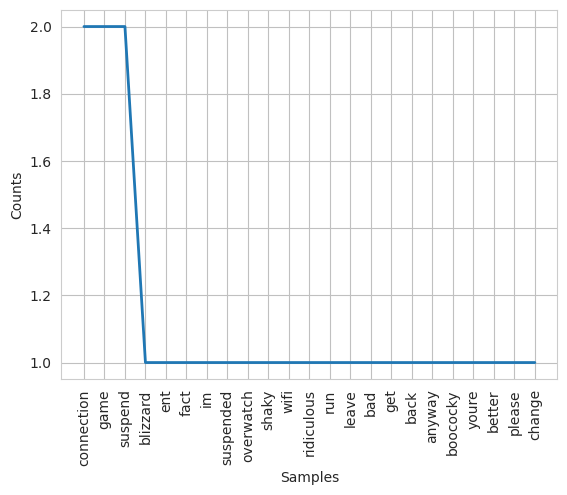

In [29]:
fdist = FreqDist(sent_filtered)

fdist.plot(30, cumulative=False)
plt.show()

Setelah dihandling stopwords nya terlihat bahwa jumlah kata tertinggi sudah bukan stopwords lagi artinya sudah berhasil handlingnya dan akan diimplementasikan nanti ke data train.

Yang selanjutnya dilakukan adalah teknik untuk mereduksi kata menjadi kata dasar. Ada 2 teknik yang akan dilakukan yaitu stemming, dan lemmatization+stemming. Akan dibandingkan hasilnya dan dipilih yang terbaik.

In [30]:
# Stemming
ps = PorterStemmer()

stemmed_words = []
for w in sent_filtered:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:", sent_filtered)
print("Stemmed Sentence:", stemmed_words)

Filtered Sentence: ['blizzard', 'ent', 'fact', 'im', 'suspended', 'overwatch', 'shaky', 'wifi', 'connection', 'ridiculous', 'run', 'leave', 'game', 'suspend', 'bad', 'connection', 'get', 'back', 'game', 'suspend', 'anyway', 'boococky', 'youre', 'better', 'please', 'change']
Stemmed Sentence: ['blizzard', 'ent', 'fact', 'im', 'suspend', 'overwatch', 'shaki', 'wifi', 'connect', 'ridicul', 'run', 'leav', 'game', 'suspend', 'bad', 'connect', 'get', 'back', 'game', 'suspend', 'anyway', 'boococki', 'your', 'better', 'pleas', 'chang']


Dari hasil stemming terlihat handling nya belum maksimal, maka akan dilakukan proses yang lain yaitu lemmatization

In [31]:
# Stemming dan Lemmatization
lem = WordNetLemmatizer()
stem = PorterStemmer()

print("Lemmatized Word:",lem.lemmatize('lying', "v"))
print("Stemmed Word:",stem.stem('lying'))

Lemmatized Word: lie
Stemmed Word: lie


In [32]:
lemmatized_words = []

for w in sent_filtered:
    lemmatized_words.append(lem.lemmatize(w))

print("Filtered Sentence:", sent_filtered)
print("Lemmatized Sentence:", lemmatized_words)

Filtered Sentence: ['blizzard', 'ent', 'fact', 'im', 'suspended', 'overwatch', 'shaky', 'wifi', 'connection', 'ridiculous', 'run', 'leave', 'game', 'suspend', 'bad', 'connection', 'get', 'back', 'game', 'suspend', 'anyway', 'boococky', 'youre', 'better', 'please', 'change']
Lemmatized Sentence: ['blizzard', 'ent', 'fact', 'im', 'suspended', 'overwatch', 'shaky', 'wifi', 'connection', 'ridiculous', 'run', 'leave', 'game', 'suspend', 'bad', 'connection', 'get', 'back', 'game', 'suspend', 'anyway', 'boococky', 'youre', 'better', 'please', 'change']


Ternyata hasil nya lebih masuk akal. Oleh karena itu, akan dipilih proses yang kedua untuk diimplementasikan ke data train.

In [33]:
df_pp.reset_index(inplace=True)

### Training Data Preprocessing

Pada bagian training data preprocessing, seperti yang disampaikan di EDA, sebelumnya akan dilakukan beberapa analisa data setelah data sudah di preprocess. Untuk melihat saja jumlah masing-masing analisa.

In [34]:
# Stopwords
df_pp['stopwords'] = df_pp['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
df_pp[['tweet','stopwords']].head()

,tweet,stopwords
0,im getting on borderlands and i will murder yo...,6
1,I am coming to the borders and I will kill you...,6
2,im getting on borderlands and i will kill you ...,5
3,im coming on borderlands and i will murder you...,5
4,im getting on borderlands 2 and i will murder ...,6


Diatas adalah jumlah stopword pada tiap tweet

In [35]:
# Punctuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

df_pp['punctuation'] = df_pp['tweet'].apply(lambda x: count_punct(x))
df_pp[['tweet','punctuation']].head()

,tweet,punctuation
0,im getting on borderlands and i will murder yo...,1
1,I am coming to the borders and I will kill you...,1
2,im getting on borderlands and i will kill you ...,1
3,im coming on borderlands and i will murder you...,1
4,im getting on borderlands 2 and i will murder ...,1


Diatas adalah jumlah tanda baca pada setiap tweet

In [36]:
# Hashtag
df_pp['hashtags'] = df_pp['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df_pp[['tweet','hashtags']].sample(20)

,tweet,hashtags
26511,i don't remember anything about idv but from w...,0
41768,Red Dead Redemption 2 is the greatest video ga...,0
46405,@ Rainbow6Game thank you for blessing the enem...,0
14703,Nice looking router,0
23092,A peacemaker is love... store.playstation.com /,0
21115,Good to have played all that Assasin's Creed!,0
53123,Johnson & Johnson to stop selling talc-based b...,0
7874,Getting there fast with The Iron Man. Obviousl...,0
3813,I would are grateful.,0
4977,I have played this interesting quiz on your Am...,0


Diatas adalah jumlah tanda pagar pada setiap tweet

In [37]:
# Numbers / Digits
df_pp['numerics'] = df_pp['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df_pp[['tweet','numerics']].sample(5)

,tweet,numerics
59994,Leaked description of Microsoft upcoming Compa...,0
7563,got a strange new xbox series x from best buy....,0
50372,LMAOOOO this video got me cryin,0
36596,"Yes, I'm not going back to verizon.",0
8208,Yes to this is right lower up my old alley. I ...,1


Diatas adalah jumlah nomor pada setiap tweet

In [38]:
# Uppercase
df_pp['upper'] = df_pp['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df_pp[['tweet','upper']].sample(5)

,tweet,upper
26612,Pile of Fan Art Sketches,0
51693,Oops... I stepped on a .,1
60320,Incredible,0
43302,Thank you for making a @ CallofDuty,0
42171,I got the horses in the back,1


Diatas adalah jumlah kata yang diawali huruf kapital pada setiap tweet

Karena sudah di cek satu per satu, akan dilakukan handling nya masing-masing

In [39]:
# membuat semua teks lowercase
df_pp['tweet'] = df_pp['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_pp['tweet'].head()

0    im getting on borderlands and i will murder yo...
1    i am coming to the borders and i will kill you...
2    im getting on borderlands and i will kill you ...
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
Name: tweet, dtype: object

In [40]:
# menghilangkan Punctuation
df_pp['tweet'] = df_pp['tweet'].apply(lambda x: re.sub(r'[!"#$%&\'()*+,-./:;<=>?@\[\\\]^_`{|}~]', '', x))
df_pp['tweet'].sample(5)

40026    knows this is nepenthez whenever theres an iss...
41906    shirleyscurry i highly recommend red dead rede...
52517     easports  eamaddennfl  shutdownsafety  espn  ...
38781    that home farm depot stage went on call of dut...
2720     with finishing the black ops cold war campaign...
Name: tweet, dtype: object

In [41]:
# menghilangkan Stopwords
stop = stopwords.words('english')

df_pp['tweet'] = df_pp['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_pp['tweet'].sample(10)

38871    like promote free packs water outside supermar...
11531                               stop love dota 2 casey
45794    rainbow6game fix servers please getting kicked...
40293                                              ea piss
19292       great google review newark site well done team
59372    pretty excited collaboration kovaak 20 experim...
12962       even limited knowledge dota 2 absolutely loved
46144                                          watch video
20656    know man died today 10 years tried fix google ...
29038                                                  unk
Name: tweet, dtype: object

Selanjutnya akan digunakan function untuk merubah semua tweet sekaligus. Dibuatkan function juga untuk memudahkan preprocessing data inference. Di bagian ini juga digunakan dataset [ini](https://www.kaggle.com/datasets/ishivinal/contractions) sebagai dictionary kata-kata slang atau singkatan-singkatan.

In [42]:
# membaca contractions.csv dan menyimpan sebagai dictionary
contractions = pd.read_csv('/content/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# define regex pattern
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# define regex emoji
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # mengganti URL menjadi '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # mengganti @USERNAME menjadi '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # mengganti 3 huruf yang sama menjadi 2 huruf untuk meringankan model
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # regex semua emoji
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # membuang semua alphanumerik dan simbol
    tweet = re.sub(alphaPattern, ' ', tweet)

    # menambah space setelah handling url
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

Selanjutnya aplikasikan function preprocessing ke keseluruhan data.

In [43]:
%%time
df_pp['processed_tweet'] = df_pp.tweet.apply(preprocess_apply)

CPU times: user 4.67 s, sys: 38.3 ms, total: 4.71 s
Wall time: 5.91 s


In [44]:
df_pp

,index,sentiment,tweet,stopwords,punctuation,hashtags,numerics,upper,processed_tweet
0,0,Positive,im getting borderlands murder,6,1,0,0,0,im getting borderlands murder
1,1,Positive,coming borders kill,6,1,0,0,2,coming borders kill
2,2,Positive,im getting borderlands kill,5,1,0,0,0,im getting borderlands kill
3,3,Positive,im coming borderlands murder,5,1,0,0,0,im coming borderlands murder
4,4,Positive,im getting borderlands 2 murder,6,1,0,1,0,im getting borderlands 2 murder
...,...,...,...,...,...,...,...,...,...
61116,61116,Positive,realized windows partition mac like 6 years be...,11,0,0,1,2,realized windows partition mac like 6 years be...
61117,61117,Positive,realized mac window partition 6 years behind n...,9,1,0,1,2,realized mac window partition 6 years behind n...
61118,61118,Positive,realized windows partition mac 6 years behind ...,11,0,0,1,1,realized windows partition mac 6 years behind ...
61119,61119,Positive,realized windows partition mac like 6 years be...,13,0,0,1,2,realized windows partition mac like 6 years be...


In [45]:
# jumlah kata
df_pp['word_count'] = df_pp['tweet'].apply(lambda x: len(str(x).split(" ")))
df_pp[['tweet','word_count']].sample(5)

,tweet,word_count
46820,unk,1
16341,got fucked fucking horrific reverse vision two...,31
56166,well damn use make look bad like 3 hours publi...,13
37244,vzwsupport sent originally direct message issu...,11
41349,mmmmm okay red dead redemption 2 part 6 paramo...,12


In [46]:
# jumlah karakter
df_pp['char_count'] = df_pp['tweet'].str.len()
df_pp[['tweet','char_count']].head()

,tweet,char_count
0,im getting borderlands murder,29
1,coming borders kill,19
2,im getting borderlands kill,27
3,im coming borderlands murder,28
4,im getting borderlands 2 murder,31


### Convert Target

Selanjutnya akan diganti target dengan representasi numerik supaya bisa masuk ke dalam model.

In [47]:
# Melihat Target

df_pp.sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [48]:
# Mengubah Target dari String ke dalam Numeric

df_pp['label'] = df_pp['sentiment'].replace({'Negative' : 0, 'Neutral' : 1, 'Positive' : 2})
df_pp

,index,sentiment,tweet,stopwords,punctuation,hashtags,numerics,upper,processed_tweet,word_count,char_count,label
0,0,Positive,im getting borderlands murder,6,1,0,0,0,im getting borderlands murder,4,29,2
1,1,Positive,coming borders kill,6,1,0,0,2,coming borders kill,3,19,2
2,2,Positive,im getting borderlands kill,5,1,0,0,0,im getting borderlands kill,4,27,2
3,3,Positive,im coming borderlands murder,5,1,0,0,0,im coming borderlands murder,4,28,2
4,4,Positive,im getting borderlands 2 murder,6,1,0,1,0,im getting borderlands 2 murder,5,31,2
...,...,...,...,...,...,...,...,...,...,...,...,...
61116,61116,Positive,realized windows partition mac like 6 years be...,11,0,0,1,2,realized windows partition mac like 6 years be...,12,77,2
61117,61117,Positive,realized mac window partition 6 years behind n...,9,1,0,1,2,realized mac window partition 6 years behind n...,12,77,2
61118,61118,Positive,realized windows partition mac 6 years behind ...,11,0,0,1,1,realized windows partition mac 6 years behind ...,12,79,2
61119,61119,Positive,realized windows partition mac like 6 years be...,13,0,0,1,2,realized windows partition mac like 6 years be...,16,97,2


### Vectorization and Embedding

Proses selanjutnya adalah vektorisasi dan embedding. Proses ini merupakan bagian dari preprocessing yang pada initinya adalah merubah kata-kata menjadi vektor representasi numeriknya. Kenapa proses ini dibutuhkan, hal ini karena komputer hanya dapat mengolah angka. Oleh karena itu untuk melakukan apapun di komputer, proses belakang layarnya adalah seperti ini.

Sebelum dilakukan vektorisasi, embedding, dan modelling, diperlukan juga splitting data. Hal ini dibutuhkan supaya untuk validasi performa model tidak terpengaruh karena model sudah belajar dari data yang bersangkutan sebelumnya.

In [49]:
# Splitting Corpus

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_pp.processed_tweet,
                                                    df_pp.label,
                                                    test_size=0.25,
                                                    random_state=46,
                                                    stratify=df_pp.label)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (45840,)
Test Size  :  (15281,)


Selanjutnya taget akan di encoding. Proses encoding juga sebetulnya merubah data kategorik ke representasi numeriknya. Kenapa tidak digunakan saja label numerik yang awal adalah karena model hanya dapat membaca angka 0 dan 1 untuk data kategorik. Oleh karena itu akan digunakan One Hot Encoding.

In [50]:
# mengganti data ke series
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

# encoding target
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)

# shape data target
print("y_train shape:", y_train.shape)

y_train shape: (45840, 3)


Selanjutnya adalah proses embedding. Embedding dilakukan dengan model Word2Vec. Word2Vec adalah library khusus embedding yang dikembangkan oleh Google. Embedding ini menggunakan 2 metode khusus yang merupakan Neural Network juga yaitu Skip Gram dan Common Bag of Words. Untuk informasi lebih lanjut mengenai Word2Vec dapat diakses pada link [ini](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

In [51]:
Embedding_dimensions = 80

# membuat dataset training Word2Vec
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [52]:
%%time

# Define model embedding dan training modelnya
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=10)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 5642
CPU times: user 7.04 s, sys: 55.6 ms, total: 7.1 s
Wall time: 6.48 s


Selanjutnya akan di tes hasil embedding dengan memasukan kata good dan melihat hasil nya.

In [53]:
word2vec_model.wv.most_similar(positive="good")

[('pretty', 0.7993379235267639),
 ('feels', 0.7753068804740906),
 ('nice', 0.7611501216888428),
 ('cool', 0.7554018497467041),
 ('quite', 0.7473082542419434),
 ('looked', 0.7388169765472412),
 ('loved', 0.7364279627799988),
 ('though', 0.7301467657089233),
 ('little', 0.7277655601501465),
 ('feeling', 0.7250931262969971)]

### Tokenization

Selanjutnya adalah proses tokenisasi. Tokenisasi adalah cara memisahkan sebagian dari teks ke bagian yang lebih kecil yang disebut **token**. Token bisa berbentuk kata, karaklter, dan lain-lain.

In [54]:
# define input length dan vocab length
input_length = 60
vocab_length = 50000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(df_pp.processed_tweet)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 50000


### Padding

Semua macam Neural Network perlu input yang sama dari mulai bentuk dan ukurannya. Namun, setelah di preprocess tidak semua elemen memiliki bentuk dan ukuran yang sama, oleh karena itu, padding dibutuhkan. Sebagai simplifikasinya, padding memberikan angka 0 untuk memenuhi kriteria bentuk atau ukuran tertentu supaya nantinya ukuran dan bentuknya sama saat dimasukan ke model.

In [55]:
# padding
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (45840, 60)
X_test.shape : (15281, 60)


### Embedding Matrix

Embedding matrix adalah matriks dari semua kata dan embedding yang sesuai. Matriks ini berisi informasi dari semua kata dan embedding nya dalam representasi vektor. bentuk dari embedding matrix biasanya **Vocab Length X Dimensi Embbeding**

In [56]:

embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (50000, 80)


# Modelling

Selanjutnya adalah Modelling. Arsitektur model yang digunakan adalah sequential. Pemilihan arsitektur ini adalah karena performanya lebih bagus dibanding functional dalam pemahaman arti dari kata. Arsitektur ini juga bagus dalam membaca elemen dari model input semacam Bag of Word dari hasil embedding.

### Baseline Model

In [57]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(3, activation='softmax'),
    ],
    name="Sentiment_Model")
    return model

In [58]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 80)            4000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          144800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                3216      
                                                   

In [59]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [60]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=50,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50
41/41 [==============================] - 19s 130ms/step - loss: 0.5683 - accuracy: 0.5484 - val_loss: 0.5255 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 4s 96ms/step - loss: 0.5129 - accuracy: 0.6056 - val_loss: 0.5084 - val_accuracy: 0.6099 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 4s 91ms/step - loss: 0.4986 - accuracy: 0.6208 - val_loss: 0.4972 - val_accuracy: 0.6246 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 4s 96ms/step - loss: 0.4915 - accuracy: 0.6267 - val_loss: 0.4867 - val_accuracy: 0.6407 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 4s 93ms/step - loss: 0.4819 - accuracy: 0.6355 - val_loss: 0.4807 - val_accuracy: 0.6468 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 4s 93ms/step - loss: 0.4754 - accuracy: 0.6424 - val_loss: 0.4809 - val_accuracy: 0.6459 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 4s 92ms/step - loss: 0

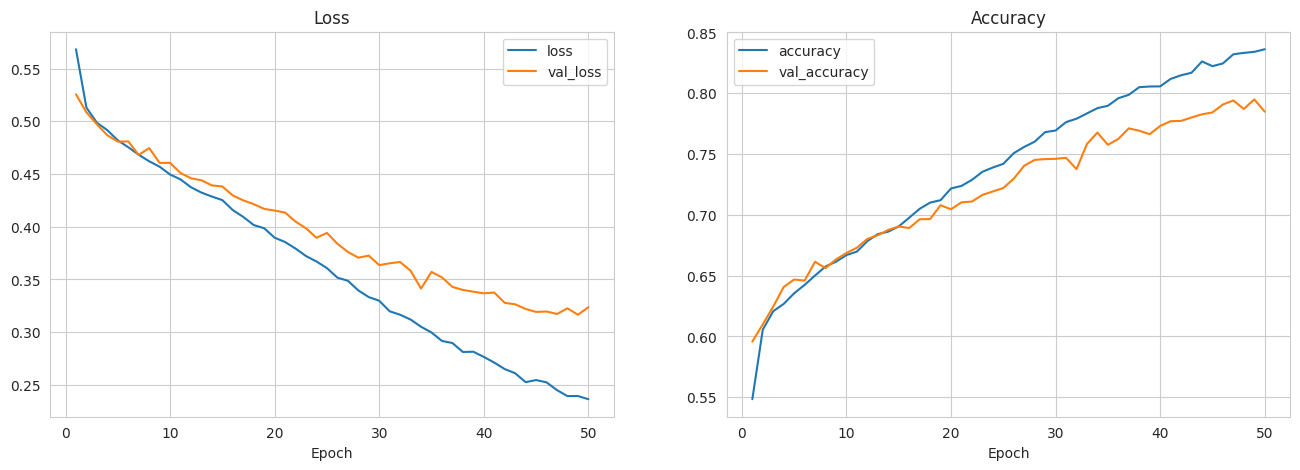

In [62]:
epoch=50

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

Dari plot model, performa model terlihat cukup baik jika dilihat dari akurasinya. Walaupun gradiennya Exploding, namun trend yang ditunjukkan adalah trend naik. Di epoch akhir, terlihat bahwa model memiliki performa yang mulai menurun. Hal ini ditunjukan dari plot yang mulai melandai. Selanjutnya akan dilakukan improvement agar akurasinya bisa semakin naik.

### Improvement Model

In [63]:
def getModel2():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model2 = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(3, activation='softmax'),
    ],
    name="Sentiment_Model2")
    return model2

In [64]:
training_model2 = getModel2()
training_model2.summary()

Model: "Sentiment_Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 80)            4000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 200)          144800    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                  

In [65]:
training_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
history2 = training_model2.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=50,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50
41/41 [==============================] - 23s 165ms/step - loss: 0.5559 - accuracy: 0.5597 - val_loss: 0.5239 - val_accuracy: 0.5955 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 4s 108ms/step - loss: 0.5095 - accuracy: 0.6088 - val_loss: 0.5113 - val_accuracy: 0.5995 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 5s 113ms/step - loss: 0.4981 - accuracy: 0.6194 - val_loss: 0.4932 - val_accuracy: 0.6291 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 5s 112ms/step - loss: 0.4885 - accuracy: 0.6306 - val_loss: 0.4859 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 4s 109ms/step - loss: 0.4803 - accuracy: 0.6363 - val_loss: 0.4776 - val_accuracy: 0.6422 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 5s 114ms/step - loss: 0.4713 - accuracy: 0.6478 - val_loss: 0.4683 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 4s 110ms/step - l

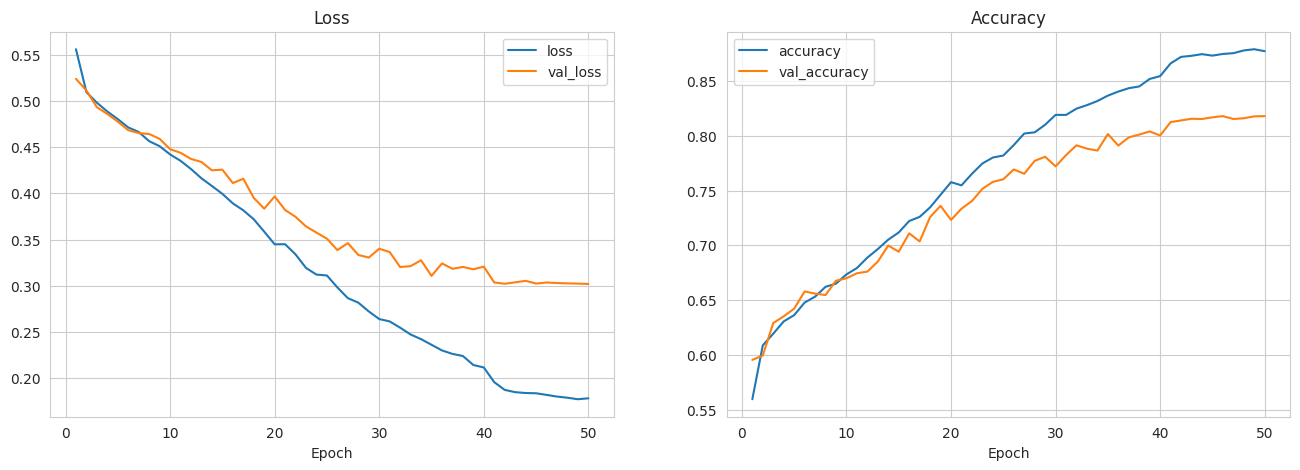

In [67]:
epoch2=50

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch2+1),history2.history['loss'],label='loss')
ax[0].plot(range(1,epoch2+1),history2.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch2+1),history2.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch2+1),history2.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

Dari improvement, terlihat skornya juga mulai naik. Dari model yang pertama angka akurasi validasinya 79%, dan model yang kedua angka akurasi validasinya di angka 82%. Artinya improvement berhasil.

# Model Evaluation

Pada bagian ini akan dilakukan evaluasi model dengan bantuan visualisasi confusion matrix dan classification report.

In [68]:
# evaluasi training
training_model2.evaluate(X_train, y_train)

1433/1433 [==============================] - 11s 8ms/step - loss: 0.1497 - accuracy: 0.9008


[0.14973975718021393, 0.9008289575576782]

In [69]:
# evaluasi test
training_model2.evaluate(X_test, y_test)

478/478 [==============================] - 3s 7ms/step - loss: 0.2885 - accuracy: 0.8208


[0.2884710729122162, 0.8207578063011169]

In [70]:
scores = training_model2.predict(X_test, verbose = 1, batch_size = 10000)
scores[:2]

2/2 [==============================] - 3s 659ms/step


array([[9.9293774e-01, 6.7073680e-03, 3.5485020e-04],
       [9.9999976e-01, 9.0346566e-09, 2.0942826e-07]], dtype=float32)

In [71]:
binary_predictions = np.where(scores == np.max(scores, axis=1, keepdims=True), 1, 0)
binary_predictions

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [72]:
def conmat_dec(y_test, binary_predictions):
    # konversi ohe
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(binary_predictions, axis=1)

    # define confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # buat visualisasi confusion matrix
    fig, ax = plt.subplots()

    # tambahkan heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # edit elemen plot
    ax.figure.colorbar(im, ax=ax)
    classes = ['Positive', 'Negative', 'Neutral']  # tentukan label
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           xlabel='Predicted label', ylabel='True label',
           title='Confusion Matrix')
    plt.xticks(rotation=45)

    # tambahkan anotasi
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # display visualisasi
    plt.tight_layout()
    plt.show()

    report = classification_report(y_true, y_pred)

    # print classification report
    print("Classification Report:")
    print(report)

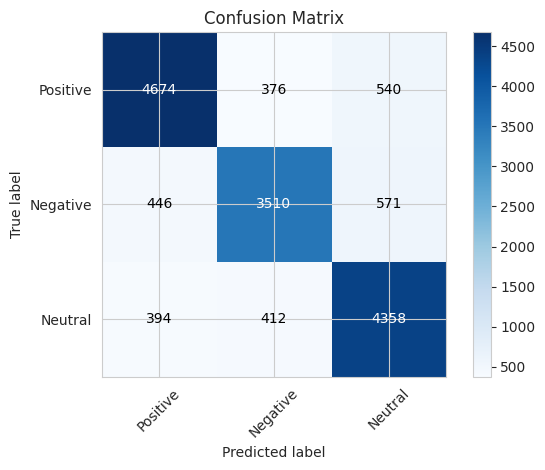

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5590
           1       0.82      0.78      0.80      4527
           2       0.80      0.84      0.82      5164

    accuracy                           0.82     15281
   macro avg       0.82      0.82      0.82     15281
weighted avg       0.82      0.82      0.82     15281



In [73]:
# panggil function evaluasi model
conmat_dec(y_test, binary_predictions)

Dari Evaluasi, terlihat bahwa model memiliki performa cukup baik dalam klasifikasi sentimen. Dapat dilihat dari jumlah prediksi yang benar mendominasi plot confusion matrix. Namun masih banyak juga yang masih salah klasifikasi. Setidaknya, model sudah bisa digunakan namun perlu bantuan manusia untuk validasi kembali hasil prediksi model. Namun dari visualisasi saat training, terlihat juga model overfitting. Hal ini nanti akan dibahas pada bagian kesimpulan.

### Save Model

In [74]:
training_model2.save('twitter_sentiment.h5')

# Kesimpulan

Kesimpulan yang dapat diambil dari pembuatan notebook ini adalah **model bisa digunakan**. Performa model cukup baik dalam melakukan prediksi nya. Perlu dicatat bahwa ini adalah prediksi dan memang model awal. Perlu dilakukan beberapa improvement kembali. Berdasarkan EDA, preprocessing, dan hasil akhir model, ada beberapa hal yang mungkin dapat dilakukan improvement.

---
1. Pada bagian EDA terlihat bahwa data sedikit imbalance. Hal ini ada kemungkinan menurunkan performa model. Sebagai analogi, hal ini sama seperti ketika kita sekolah dan ada pekan ujian sekolah. Waktu proses belajar, apa yang kita pelajari adalah bab 1 sub-bab 1, bab 2 sub-bab 2, dan bab 3 sub-bab 3. Namun apa yang diuji ternyata bab 1 sub-bab 1 dan 2, bab 2 sub-bab 2, dan bab 3 sub-bab 2 dan 3. Kita belum belajar semuanya. Sehingga akhirnya waktu ujian kita hanya bisa menjawab apa yang sudah kita pelajari. Nilai ujian kita pun tidak akan maskimal.

2. Dari bagian preprocessing, ada kemungkinan masih belum semua elemen di preprocess. Sehingga data yang masuk ke model termasuk "kotor". Mungkin sebagai improvement nanti bisa di cek kembali apakah preprocessing datanya sudah maksimal atau belum.

3. Selanjutnya dari modelling. Model yang digunakan memiliki performa yang kurang maksimal. Hal ini ada kemungkinan disebabkan oleh terlalu banyak parameter yang digunakan. Pada saat pembuatan model, saya berpikir bahwa untuk analisa sentimen dibutuhkan model yang rumit. Tetapi, jika ditinjau kembali, ternyata data tidak terlalu rumit dan mungkin ada pattern yang seharusnya bisa dilakukan oleh model yang lebih sederhana. Sebagai analogi, hal ini sama seperti ketika seorang sarjana memecahkan kasus matematika sederhana seperti penjumlahan. Sarjana melakukan proses perhitungan dengan mengganti bentuk dari angka-angkanya lalu proses lain-lain  baru di lakukan penjumlahan yang ternyata hasilnya melenceng sedikit. Sama seperti kasus sarjana ini, model yang dibuat terlalu "pintar" sehingga untuk menyelesaikan proses yang sederhana saja menjadi rumit. Oleh karena itu, sebagai improvement, model bisa dibuat lebih sederhana lagi.

---

Dari pengerjaan model ini, sebagai business insight, model ini bisa di implementasikan walaupun butuh improvement. Model ini perlu diawasi saat "bekerja". Prediksi model ini memang cukup baik, namun perlu divalidasi ulang oleh manusia. Setidaknya, dengan model ini, data yang banyak bisa di filter dengan cepat. Perlu diingat juga bahwa model hanya melakukan proses yang membosankan dan berulang. Untuk selanjutnya, sumber daya manusia yang dibutuhkan jauh lebih sedikit dibanding saat ketiadaan modelnya. Secara bisnis, ini hal yang sangat menguntungkan secara ekonomi karena tidak perlu tenaga lebih untuk handle kasus ini.


# Inference

In [75]:
inf

,full_text
0,Will someone please get David Grusch in a SCIF...
1,David Grusch told Liberation Times: “Congress...
2,David Grusch responds to Rep. Mike Turner’s co...
3,David Grusch told Liberation Times: “Congress...
4,The late Nat Kobitz... a key figure in the Dav...
...,...
725,6pm on @NewsNation: David Grusch - a veteran o...
726,UFO Whistleblower David Grusch says the US Gov...
727,Ross Coulthart on UFO whistleblower David Grus...
728,Ross Coulthart will be interviewing recently r...


In [76]:
inf['full_text'] = inf['full_text'].apply(lambda x: preprocess_apply(x))
inf

,full_text
0,will someone please get david grusch in a scif...
1,david grusch told liberation times congress...
2,david grusch responds to rep mike turner s co...
3,david grusch told liberation times congress...
4,the late nat kobitz a key figure in the davi...
...,...
725,6pm on <user> david grusch a veteran of the ...
726,ufo whistleblower david grusch says the us gov...
727,ross coulthart on ufo whistleblower david grus...
728,ross coulthart will be interviewing recently r...


In [77]:
x_data_val = pad_sequences(tokenizer.texts_to_sequences(inf.full_text), maxlen = input_length)

print("X Validation Shape:",x_data_val.shape)

X Validation Shape: (730, 60)


In [78]:
x_scores = training_model2.predict(x_data_val, verbose = 1, batch_size = 2)
x_scores[:2]

365/365 [==============================] - 2s 6ms/step


array([[4.5501435e-01, 5.4192406e-01, 3.0615514e-03],
       [2.0008748e-04, 9.6695119e-01, 3.2848757e-02]], dtype=float32)

In [80]:
df = pd.DataFrame(x_scores, columns=['Positive', 'Negative', 'Neutral'])
new_df = pd.DataFrame(np.where(x_scores == np.max(x_scores, axis=1, keepdims=True), True, False), columns=['Positive_class', 'Negative_class', 'Neutral_class'])
# Append new DataFrame to the existing DataFrame (df)
df = pd.concat([df, new_df], axis=1)
condf = pd.concat([inf, df], axis=1)
condf.head()

,full_text,Positive,Negative,Neutral,Positive_class,Negative_class,Neutral_class
0,will someone please get david grusch in a scif...,4.550143e-01,0.541924,3.061551e-03,False,True,False
1,david grusch told liberation times congress...,2.000875e-04,0.966951,3.284876e-02,False,True,False
2,david grusch responds to rep mike turner s co...,3.228045e-08,0.917618,8.238161e-02,False,True,False
3,david grusch told liberation times congress...,2.000875e-04,0.966951,3.284876e-02,False,True,False
4,the late nat kobitz a key figure in the davi...,3.664852e-07,1.000000,5.111700e-08,False,True,False


In [81]:
# Buat kolom baru 'Sentiment' berdasarkan nilai maksimum dari setiap baris
condf['Sentiment'] = condf[['Positive_class', 'Negative_class', 'Neutral_class']].idxmax(axis=1)
condf['Sentiment'] = condf['Sentiment'].str.replace('_class', '')  # Hapus '_class' dari nama kategori

In [82]:
condf.sample(10)

,full_text,Positive,Negative,Neutral,Positive_class,Negative_class,Neutral_class,Sentiment
696,in a newsnation exclusive air force veteran d...,1.024777e-08,1.000000,1.099515e-09,False,True,False,Negative
96,huge statement we tried to get in a scif w...,1.411266e-03,0.998543,4.564283e-05,False,True,False,Negative
180,<user> david grusch shapeshifting back into hi...,5.606662e-02,0.482851,4.610827e-01,False,True,False,Negative
349,chris mellon just pulled a david grusch he ju...,5.764147e-03,0.994229,7.079617e-06,False,True,False,Negative
244,get david grusch on 60 minutes as soon as poss...,9.842770e-04,0.045262,9.537539e-01,False,False,True,Neutral
725,6pm on <user> david grusch a veteran of the ...,1.586001e-01,0.840603,7.967571e-04,False,True,False,Negative
547,jeremy corbell amp george knapp release davi...,4.356253e-07,0.000374,9.996254e-01,False,False,True,Neutral
384,<user> <user> <user> great but i hope the hea...,1.338049e-04,0.999354,5.120927e-04,False,True,False,Negative
551,rep burchette of the house oversight committee...,1.096470e-06,0.999998,4.469962e-07,False,True,False,Negative
266,grusch has stated that he will provide a speci...,3.133622e-02,0.968188,4.761811e-04,False,True,False,Negative
